In [13]:
import pandas as pd
import numpy as np
import sys, os
from importlib import reload

# Append path for testing - use pyproject for the future
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import analysis_functions as f
reload(f)


<module 'analysis_functions' from 'c:\\Users\\asacco\\OneDrive - Plymouth Rock Assurance Corp\\Desktop\\repos\\analysis_tools\\src\\analysis_functions.py'>

In [14]:
df = pd.read_csv("../data/bank-full.csv", delimiter=';')

In [15]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [36]:
# Convert 'y' to numeric for analysis
df["target"] = np.where(df["y"] == "no", 0, 1)

# Add weights to test weight functionality of plot_target_vs_predictors()
df["weights"] = np.abs(np.random.randn(len(df.index)))

# Add faux prediction column for testing functions
df["pred"] = (df["target"] + np.random.normal(size=len(df.index))).clip(0, 1)

# Add an arbitrary data split for testing functions
df["split"] = np.where(df.index > int(df.shape[0] * 0.70), "V", "T")

In [37]:
df["split"].value_counts(dropna=False, normalize=True)

T    0.700007
V    0.299993
Name: split, dtype: float64

In [38]:
df[["pred", "target"]].describe()

,pred,target
count,45211.000000,45211.000000
mean,0.358612,0.116985
std,0.414651,0.321406
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.108030,0.000000
75%,0.814157,0.000000
max,1.000000,1.000000


## plot_target_vs_predictors function

In [17]:
predictors =  ["job", "balance", "contact", "duration", "marital", "job", "pdays", "previous"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

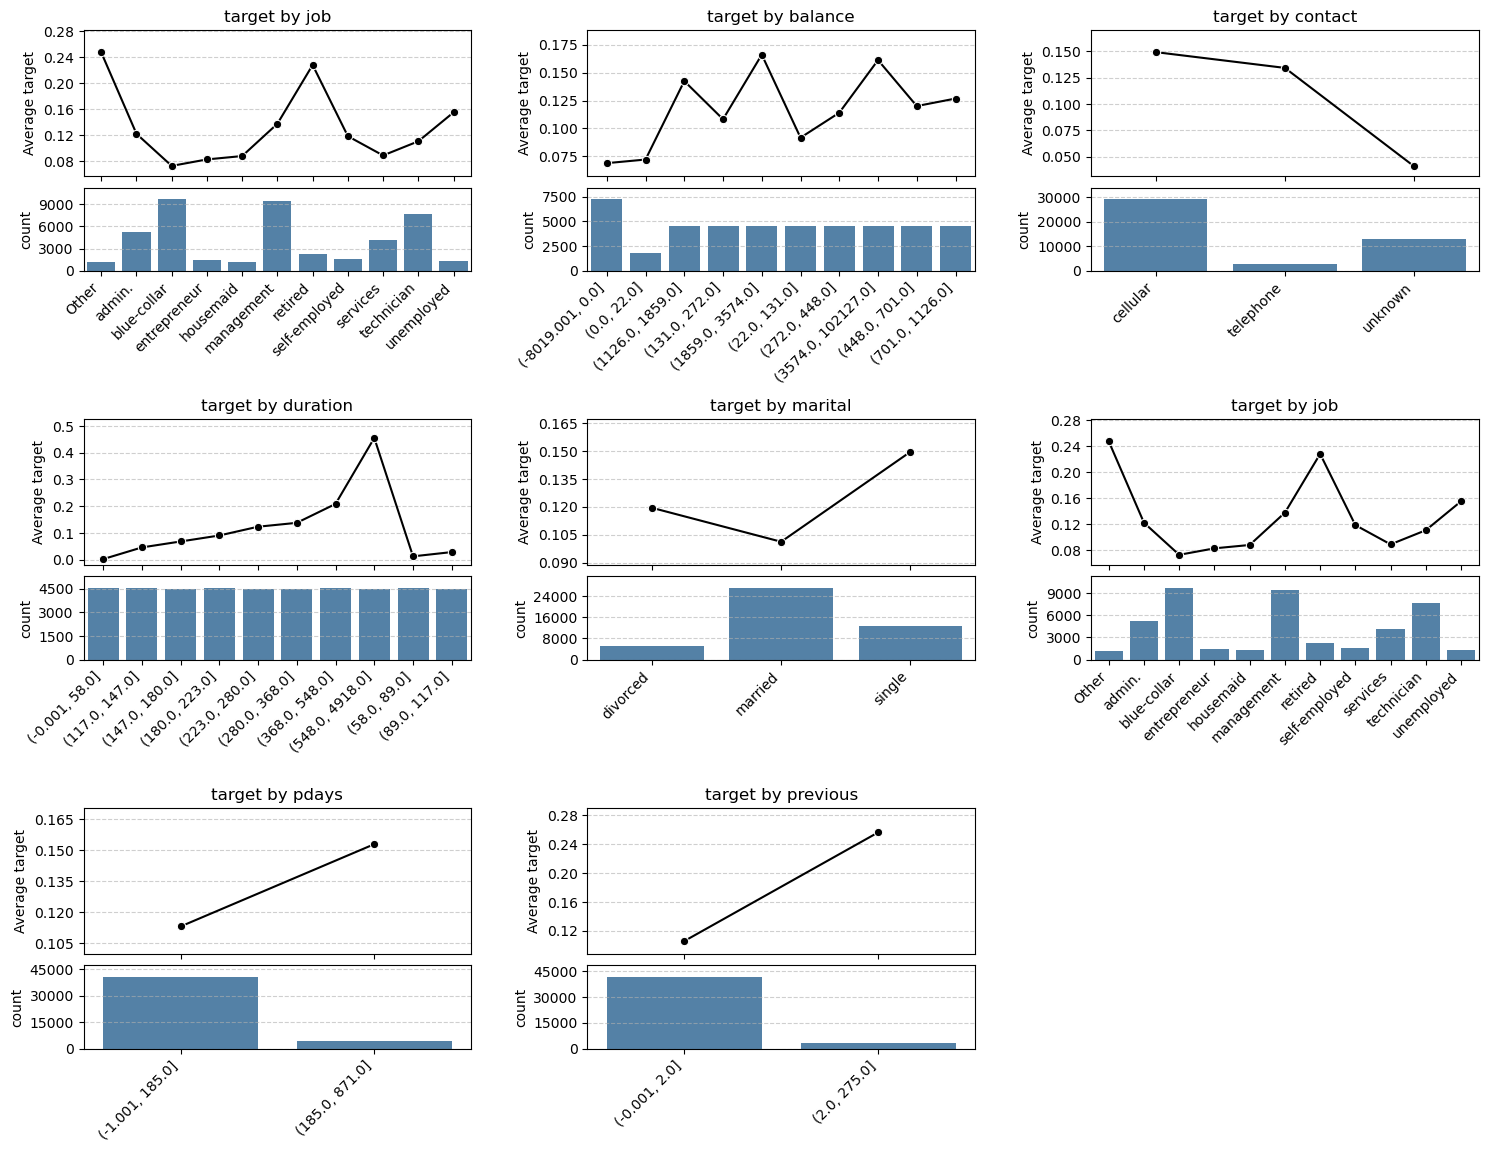

In [18]:
reload(f)
f.plot_target_vs_predictors(df, "target", predictors)

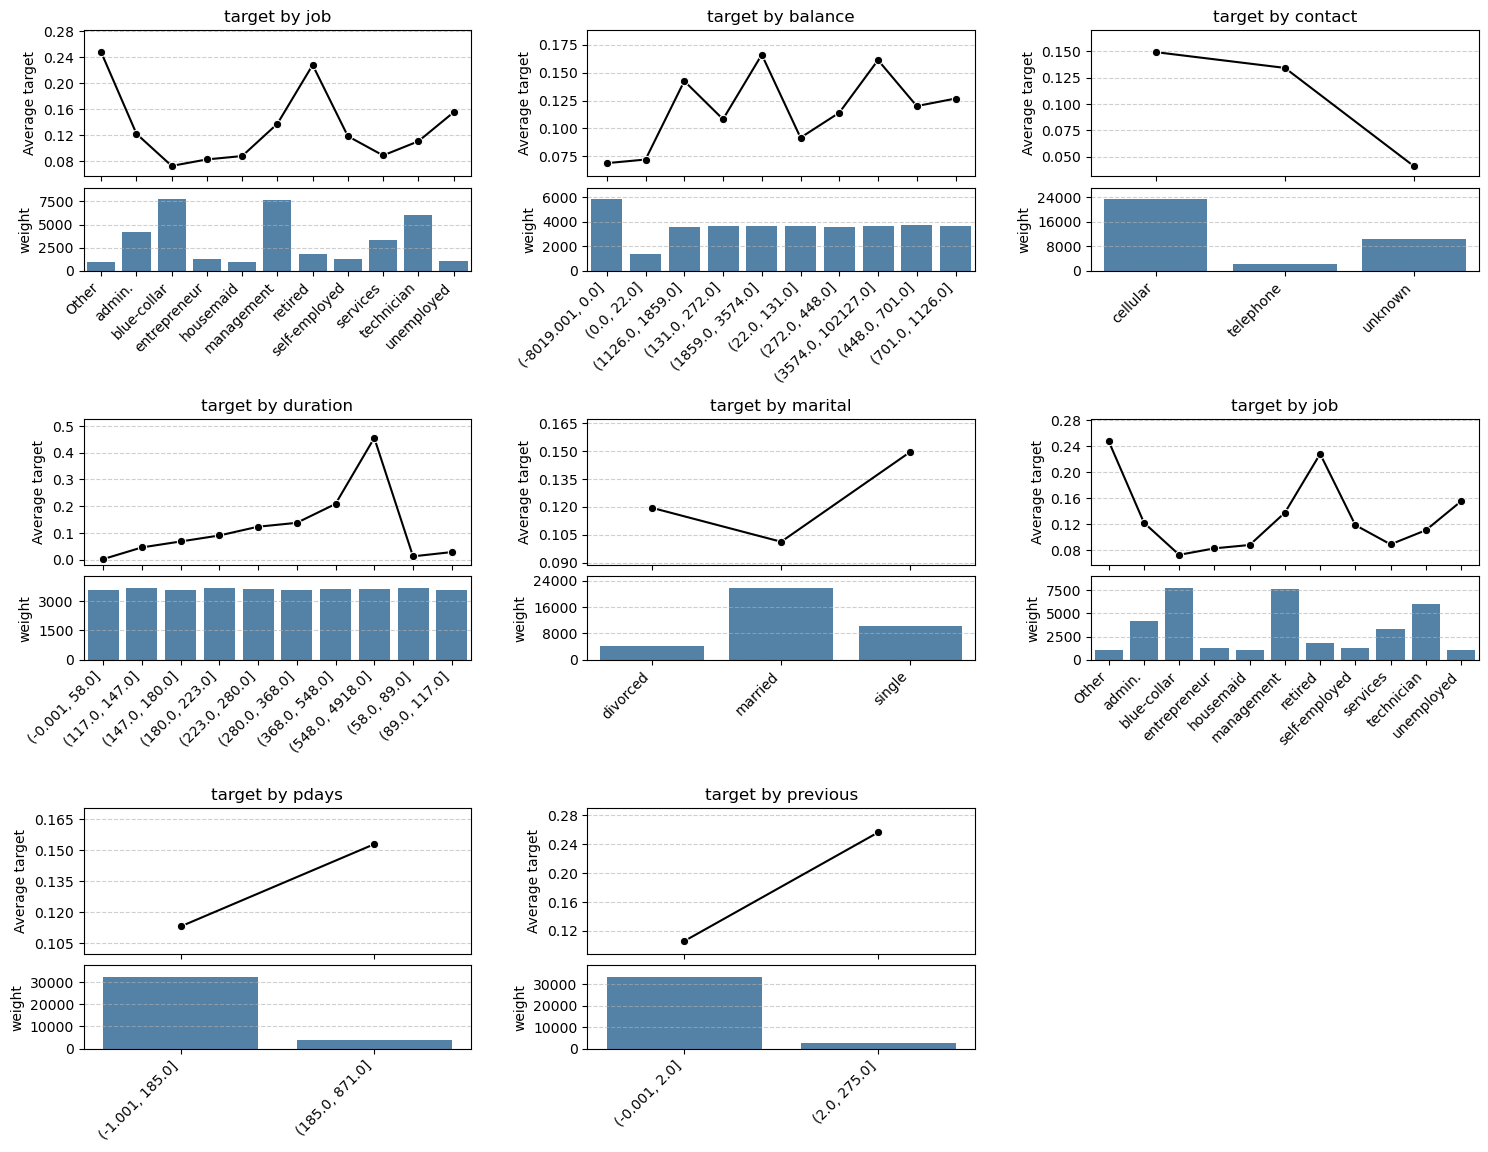

In [19]:
f.plot_target_vs_predictors(df, "target", predictors, weight_col="weights")

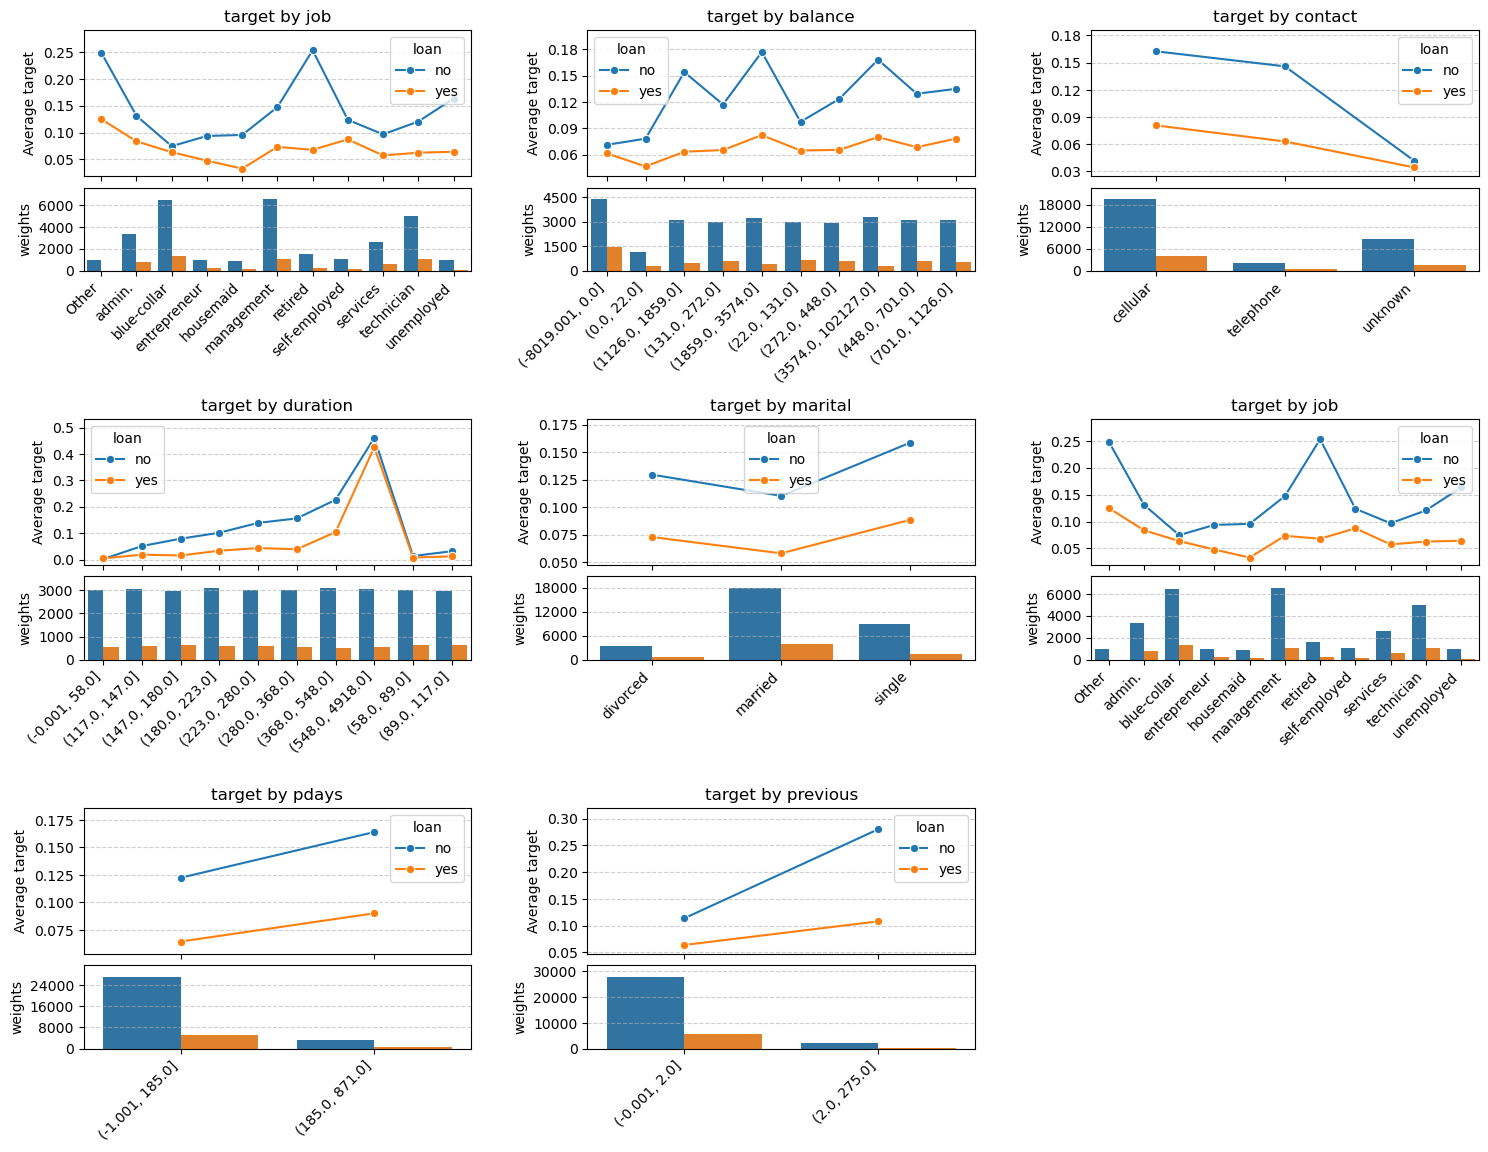

In [20]:
reload(f)
f.plot_target_vs_predictors(df, "target", predictors, group_col="loan", weight_col="weights")

## plot_variable_distributions function

In [24]:
# f.plot_variable_distributions(df, predictors, bins=30)

## Explore creation of tabulation function and object

In [46]:
def generate_tabulations(
    df: pd.DataFrame,
    prediction_col: str,
    truth_col: str,
    group_vars: list,
    weights_col=None,
    split_col=None,
    n_bins=5,
):
    """
    Generate tabulations comparing prediction vs. ground truth across variables and splits.

    Args:
        df (pd.DataFrame): Input DataFrame.
        prediction_col (str): Name of the prediction column.
        truth_col (str): Name of the ground truth column.
        group_vars (list): List of variables (categorical or numeric) to group by.
        weights_col (str, optional): Name of weights column. Defaults to None.
        split_col (str, optional): Column name indicating data split (e.g. "split"). Defaults to None.
        n_bins (int): Number of bins for numeric variables. Defaults to 5.

    Returns:
        dict: Dictionary of tabulation DataFrames keyed by grouping variable name.
    """
    output = {}
    df = df.copy()

    # Handle weights
    df["_w"] = df[weights_col] if weights_col else 1.0

    # Precompute weighted values
    df["_pred_weighted"] = df[prediction_col] * df["_w"]
    df["_truth_weighted"] = df[truth_col] * df["_w"]

    for var in group_vars:
        # Bin numeric columns
        if np.issubdtype(df[var].dtype, np.number) and df[var].nunique() > n_bins:
            group_col = f"{var}_binned"
            df[group_col] = pd.qcut(df[var], q=n_bins, duplicates='drop')
        else:
            group_col = var

        # Grouping columns
        groupby_cols = [group_col]
        if split_col:
            groupby_cols.append(split_col)

        # Aggregation
        agg_dict = {
            "_w": "sum",
            "_pred_weighted": "sum",
            "_truth_weighted": "sum",
        }

        tab = df.groupby(groupby_cols).agg(agg_dict).reset_index()
        tab.rename(columns={"_w": "weight_sum"}, inplace=True)

        # Compute weighted means and log ratio error
        tab["prediction_mean"] = tab["_pred_weighted"] / tab["weight_sum"]
        tab["truth_mean"] = tab["_truth_weighted"] / tab["weight_sum"]
        tab["lr_error"] = tab["truth_mean"] / tab["prediction_mean"]

        # Final columns
        columns_to_keep = groupby_cols + ["weight_sum", "prediction_mean", "truth_mean", "lr_error"]
        output[var] = tab[columns_to_keep]

    return output

def pivot_tabulation_wide(tab_df, split_col="split", group_col="job"):
    """
    Convert a long-format tabulation DataFrame into a wide-format version,
    grouping columns by split (e.g., T and V).

    Args:
        tab_df (pd.DataFrame): Long-format tabulation output from `generate_tabulations`.
        split_col (str): Column name for data splits.
        group_col (str): Column name to group by (e.g., categorical variable like 'job').

    Returns:
        pd.DataFrame: Wide-format DataFrame with grouped columns by split.
    """
    # Identify metric columns (exclude group and split)
    value_cols = [col for col in tab_df.columns if col not in [group_col, split_col]]

    # Pivot table into wide format
    tab_wide = tab_df.pivot(index=group_col, columns=split_col, values=value_cols)

    # Reorder columns to group by split: e.g., T: all metrics, then V: all metrics
    new_cols = []
    for split in tab_df[split_col].unique():
        for metric in value_cols:
            new_cols.append((metric, split))

    # Flatten multi-index
    tab_wide = tab_wide.reindex(columns=pd.MultiIndex.from_tuples(new_cols))
    tab_wide.columns = [f"{split}_{metric}" for metric, split in tab_wide.columns]

    # Bring group_col back as a column
    tab_wide.reset_index(inplace=True)

    return tab_wide




In [ ]:
tabs = generate_tabulations(
    df=df,
    prediction_col="pred",
    truth_col="target",
    group_vars=predictors,
    weights_col="weights",
    split_col="split",
    n_bins=10,
)


In [47]:
tabs["job"]

,job,split,weight_sum,prediction_mean,truth_mean,lr_error
0,admin.,T,2660.161113,0.351690,0.066773,0.189863
1,admin.,V,1396.536559,0.386820,0.230064,0.594756
2,blue-collar,T,5496.393891,0.334466,0.048895,0.146188
3,blue-collar,V,2206.275755,0.357132,0.127946,0.358261
4,entrepreneur,T,951.120164,0.316601,0.054072,0.170788
5,entrepreneur,V,267.617396,0.349812,0.177145,0.506402
6,housemaid,T,778.784012,0.327265,0.040624,0.124131
7,housemaid,V,213.239574,0.427658,0.279970,0.654657
8,management,T,5333.323740,0.334530,0.062990,0.188293
9,management,V,2203.046218,0.441771,0.306627,0.694085


In [48]:
pivot_tabulation_wide(tabs["job"], split_col="split", group_col="job")

,job,T_weight_sum,T_prediction_mean,T_truth_mean,T_lr_error,V_weight_sum,V_prediction_mean,V_truth_mean,V_lr_error
0,admin.,2660.161113,0.351690,0.066773,0.189863,1396.536559,0.386820,0.230064,0.594756
1,blue-collar,5496.393891,0.334466,0.048895,0.146188,2206.275755,0.357132,0.127946,0.358261
2,entrepreneur,951.120164,0.316601,0.054072,0.170788,267.617396,0.349812,0.177145,0.506402
3,housemaid,778.784012,0.327265,0.040624,0.124131,213.239574,0.427658,0.279970,0.654657
4,management,5333.323740,0.334530,0.062990,0.188293,2203.046218,0.441771,0.306627,0.694085
5,retired,961.693779,0.343116,0.072096,0.210121,845.850842,0.439010,0.391469,0.891707
6,self-employed,944.489742,0.337960,0.062361,0.184522,317.326467,0.417547,0.289482,0.693291
7,services,2333.198665,0.313752,0.045081,0.143684,943.391634,0.384655,0.195777,0.508969
8,student,229.135538,0.392889,0.087345,0.222315,504.895135,0.451267,0.358073,0.793485
9,technician,4659.689223,0.338153,0.062011,0.183382,1520.395438,0.420762,0.268389,0.637865


In [31]:
tabs["duration"]

,duration_binned,weight_sum,prediction_mean,truth_mean,lr_error
0,"(-0.001, 58.0]",3623.009924,0.009748,0.002397,0.245911
1,"(58.0, 89.0]",3655.742575,0.010957,0.012449,1.136143
2,"(89.0, 117.0]",3571.163283,0.019154,0.028471,1.486403
3,"(117.0, 147.0]",3632.367910,0.041297,0.046855,1.134561
4,"(147.0, 180.0]",3575.552668,0.080321,0.070316,0.875440
5,"(180.0, 223.0]",3590.126141,0.099720,0.093555,0.938175
6,"(223.0, 280.0]",3644.419265,0.139111,0.126092,0.906414
7,"(280.0, 368.0]",3517.046303,0.152627,0.136912,0.897040
8,"(368.0, 548.0]",3604.723514,0.171304,0.212295,1.239286
9,"(548.0, 4918.0]",3635.321138,0.430867,0.447066,1.037596
